In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Bidirectional,RepeatVector,Concatenate,Activation,Dot,Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import preprocessing,utils

**Downloading Data**

In [2]:
# !pip install wget
# import wget
# url = 'https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch08/spa.txt'
# wget.download(url,'/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/spa.txt')

**Creating Datasets**

In [3]:
# reading data
with open('/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/spa.txt',encoding='utf-8',errors='ignore') as file:
  text=file.read().split('\n')

In [4]:
input_texts=[] #encoder input
target_texts=[] # decoder input

In [5]:
# we will select subset of the whole data
NUM_SAMPLES = 10000
for line in text[:NUM_SAMPLES]:
  english, spanish = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

**Data Preprocessing**

In [6]:
# We remove punctuation characters from the data
regex = re.compile('[%s]' %re.escape(string.punctuation))
for s in input_texts:
  regex.sub('', s)  
for s in target_texts:
  regex.sub('', s)

**Tokenizing Data**

In [8]:
tokenizer_input = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(input_texts, target_vocab_size=2**13)

In [9]:
# example showing how this tokenizer works
tokenized_string1=tokenizer_input.encode('hello i am good')
tokenized_string1

[2269, 1, 41, 89]

In [11]:
tokenizer_out=tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(target_texts, target_vocab_size=2**13)

In [13]:
# add tokens for start and end tags for both the input and output
START_TOKEN_in=[tokenizer_input.vocab_size]
#input start token
END_TOKEN_in=[tokenizer_input.vocab_size+1]
#input end token
START_TOKEN_out=[tokenizer_out.vocab_size]
#output start token
END_TOKEN_out=[tokenizer_out.vocab_size+1]
#output end token/
START_TOKEN_in,END_TOKEN_in,START_TOKEN_out,END_TOKEN_out

([2974], [2975], [5737], [5738])

In [14]:
# function for tokenizing and padding out both the datasets
MAX_LENGTH = 10

# Tokenize, filter and pad sentences
def tokenize_and_padding(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (input_sentence, output_sentence) in zip(inputs, outputs):
    # tokenize sentence
    input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
    output_sentence = START_TOKEN_out + tokenizer_out.encode(output_sentence) + END_TOKEN_out

    # check tokenized sentence max length
    if len(input_sentence) <= MAX_LENGTH and len(output_sentence) <= MAX_LENGTH:
      tokenized_inputs.append(input_sentence)
      tokenized_outputs.append(output_sentence)

  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH,padding='post'
  )
  tokenized_outputs =tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH,padding='post'
  )

  return tokenized_inputs, tokenized_outputs

In [15]:
english, spanish = tokenize_and_padding(input_texts,target_texts)

In [17]:
english[1], spanish[1]

(array([2974,   50, 2764, 2975,    0,    0,    0,    0,    0,    0],
       dtype=int32),
 array([5737, 1017, 5527, 5738,    0,    0,    0,    0,    0,    0],
       dtype=int32))

**Preparing Dataset for Training**

In [18]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

In [21]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            'inputs': english,
            'decoder_inputs': spanish[:, :-1]
         },
        {
            'outputs':spanish[:, 1:]
         },
     )
)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

**Transformer Model**

***Multi-Head Attention***

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    self.depth = d_model // self.num_heads
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)
    self.dense = tf.keras.layers.Dense(units=d_model)
  
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, 
        shape=(batch_size, -1,self.num_heads, self.depth)
        )
    return tf.transpose(inputs, perm=[0, 2, 1, 3])
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'],inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)
    
    return outputs

***Function for Scaled Dot-Product Attention***

In [23]:
def scaled_dot_product_attention(query, key, value, mask):
  QxK_transpose = tf.matmul(query, key, transpose_b=True)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = QxK_transpose / tf.math.sqrt(depth)
  
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)
  output = tf.matmul(attention_weights, value)
  return output

***Encoder Architecture***

In [24]:
# Masking Functions
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [25]:
x=tf.constant([[2974, 50, 2764, 2975, 0, 0,
0, 0, 0, 0]])
create_padding_mask(x)

<tf.Tensor: shape=(1, 1, 1, 10), dtype=float32, numpy=array([[[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)>

In [26]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

***PositionalEncoding Class***

In [28]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model
    )

    # apply sine to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])

    # apply cosine to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

***Encoder Layer***

In [29]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # multi-head attention with padding mask
  attention = MultiHeadAttention(d_model, num_heads, name="attention")({
      'query': inputs,
      'key': inputs,
      'value': inputs,
      'mask': padding_mask
  })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # two dense layers followed by a dropout
  outputs = tf.keras.layers.Dense(units=units,activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

***Encoder***

In [30]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
  inputs = tf.keras.Input(shape=(None,),name="inputs")

  # create padding mask
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # create combination of word embedding + positional encoding
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  
  # repeat the Encoder Layer two times
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),)([outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

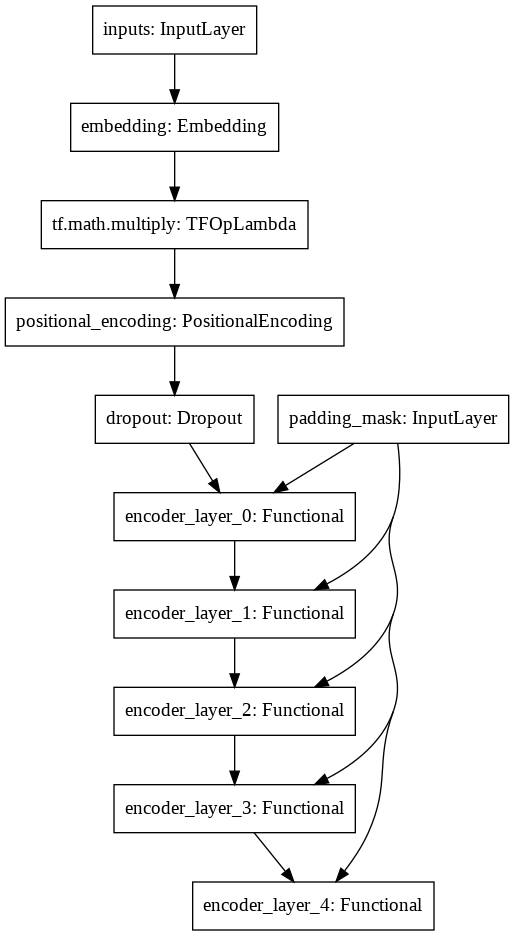

In [31]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=5,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")
tf.keras.utils.plot_model(sample_encoder, to_file='encoder.png')

**Decoder Architecture**

In [34]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model),name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
      inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
          }
  )
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
  attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
      inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
          }
  )
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
  outputs = tf.keras.layers.Dense(units=units,activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask,padding_mask],
      outputs=outputs,
      name=name
  )

In [35]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

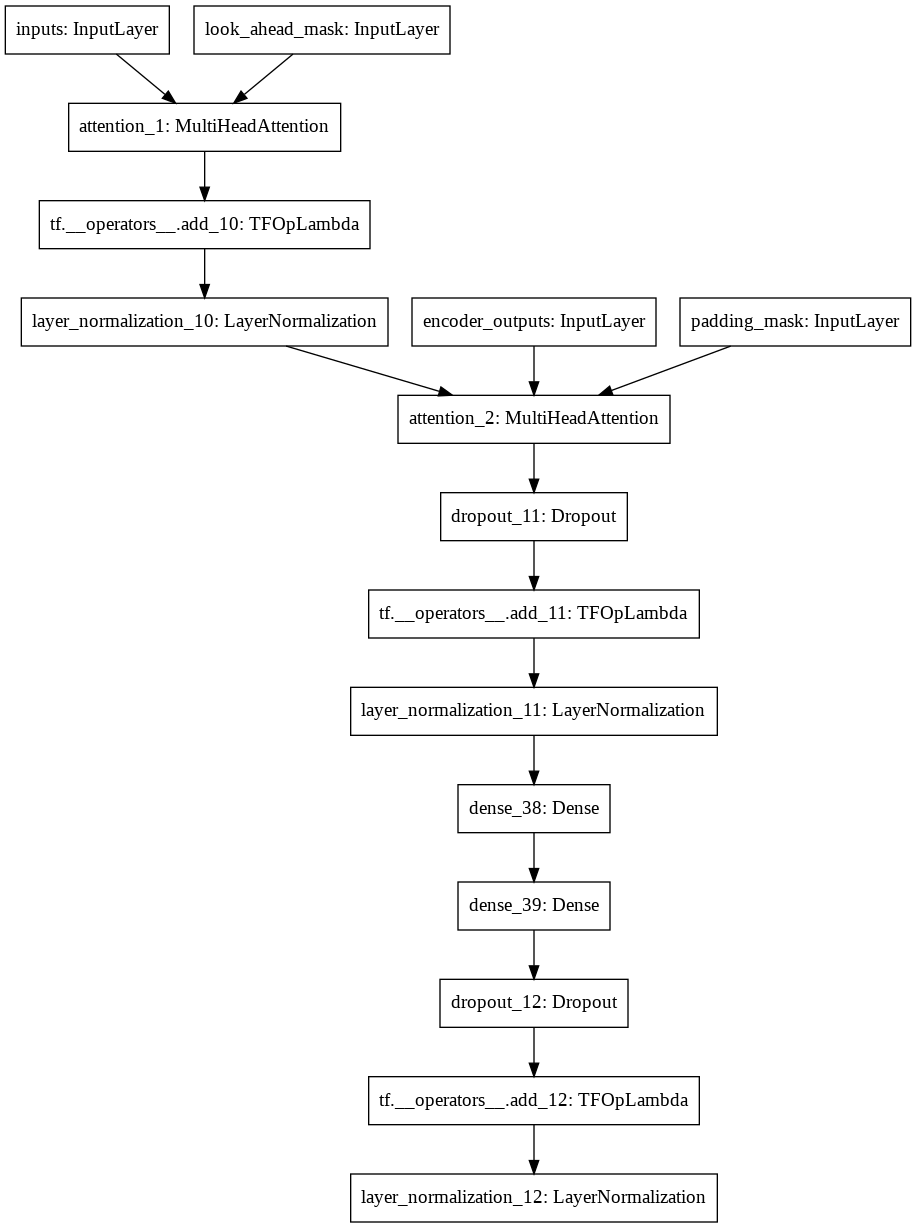

In [36]:
tf.keras.utils.plot_model(sample_decoder_layer,to_file='decoder_layer.png')

**Decoder**

In [40]:
def decoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name='decoder'):
  inputs = tf.keras.Input(shape=(None,),name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model),name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None),name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask,padding_mask],
      outputs=outputs,
      name=name
  )

In [41]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder"
)

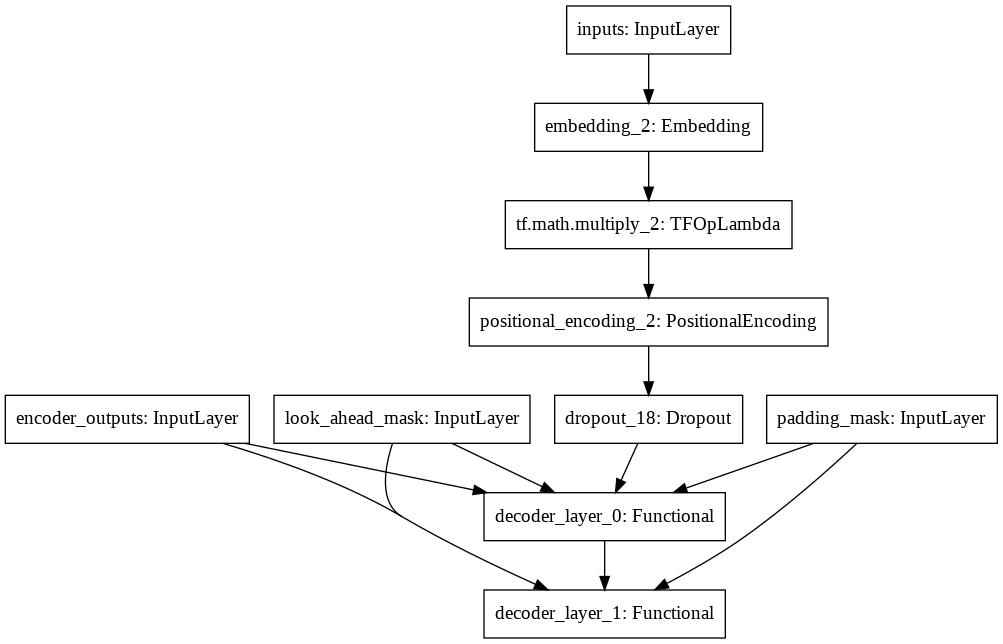

In [42]:
tf.keras.utils.plot_model(sample_decoder, to_file='decoder.png')

**Transformer Model**

In [43]:
def transformer(input_vocab_size, target_vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, 
      output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask'
  )(dec_inputs)

  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, 
      output_shape=(1, 1, None),
      name='dec_padding_mask'
  )(inputs)

  enc_outputs = encoder(
      vocab_size=input_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=target_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=target_vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [44]:
sample_transformer = transformer(
    input_vocab_size = 100,
    target_vocab_size = 100,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer"
)

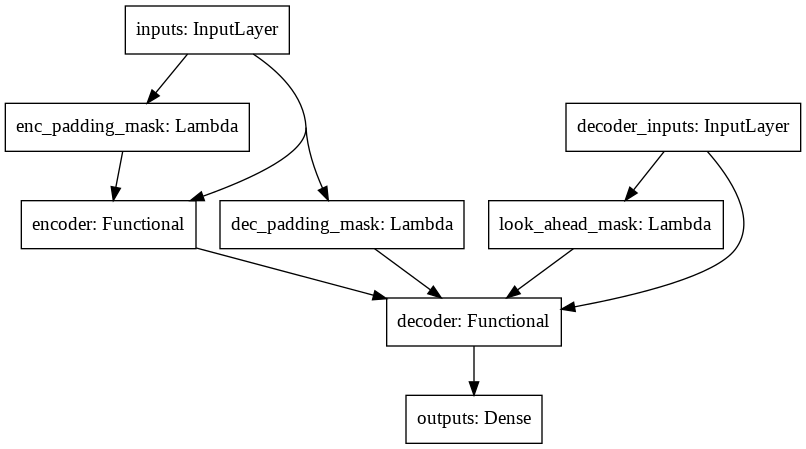

In [45]:
tf.keras.utils.plot_model(sample_transformer, to_file='transformer.png')

Creating Model for Training

In [46]:
D_MODEL = 256
model = transformer(
    tokenizer_input.vocab_size+2,
    tokenizer_out.vocab_size+2,
    num_layers = 2,
    units = 512,
    d_model = D_MODEL,
    num_heads = 8,
    dropout = 0.1
)

**Loss Function**

In [48]:
def loss(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, 10 - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, 
      reduction='none'
  )(y_true, y_pred)
  
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)
  return tf.reduce_mean(loss)

**Optimizer**

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

**Compiling**

In [50]:
model.compile(optimizer='adam', loss=loss)

Training

In [52]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
313/313 [==============================] - 76s 243ms/step - loss: 0.3597
Epoch 2/20
313/313 [==============================] - 77s 244ms/step - loss: 0.3554
Epoch 3/20
313/313 [==============================] - 76s 243ms/step - loss: 0.3456
Epoch 4/20
313/313 [==============================] - 77s 245ms/step - loss: 0.3312
Epoch 5/20
313/313 [==============================] - 78s 249ms/step - loss: 0.3139
Epoch 6/20
313/313 [==============================] - 77s 245ms/step - loss: 0.3125
Epoch 7/20
313/313 [==============================] - 77s 246ms/step - loss: 0.3079
Epoch 8/20
313/313 [==============================] - 76s 243ms/step - loss: 0.3053
Epoch 9/20
313/313 [==============================] - 77s 247ms/step - loss: 0.2967
Epoch 10/20
313/313 [==============================] - 76s 244ms/step - loss: 0.2960
Epoch 11/20
313/313 [==============================] - 76s 242ms/step - loss: 0.2844
Epoch 12/20
313/313 [==============================] - 77s 245ms/step - lo

**Inference**

In [58]:
def translate(input_sentence):
  input_sentence = START_TOKEN_in + tokenizer_input.encode(input_sentence) + END_TOKEN_in
  encoder_input = tf.expand_dims(input_sentence, 0)
  decoder_input = [tokenizer_out.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[encoder_input,output], training=False)

    # select the last word
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # terminate on END_TOKEN
    if tf.equal(predicted_id, END_TOKEN_out[0]):
      break

    # concatenated the predicted_id to the output
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

**Testing**

In [59]:
test_sentences = ['i am sorry', 'how are you']
for s in test_sentences:
  prediction = translate(s)
  predicted_sentence = tokenizer_out.decode([i for i in prediction if i < tokenizer_out.vocab_size])
  print('Input: {}'.format(s))
  print('Output: {}'.format(predicted_sentence))

Input: i am sorry
Output: lo siento.
Input: how are you
Output: ¡estás de ti!


---